<a href="https://colab.research.google.com/github/Zaheer-10/NeuralNetHub/blob/main/Machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Language Translation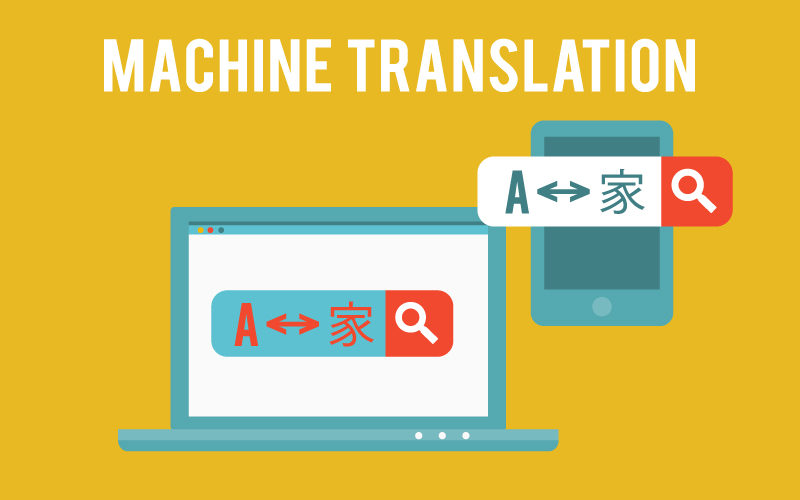

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_path = '/content/drive/MyDrive/Datasets/fin-eng/fin.txt'

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input , LSTM , Dense
import numpy as np

In [5]:
batch_size = 64
epochs = 100
latent_dim = 256
num_samples = 10000

**Vectorization **

In [6]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path , 'r' , encoding = 'utf-8') as f:
  lines = f.read().split('\n')

for line in lines [: min(num_samples , len(lines)-1)]:
  input_text ,target_text,_ = line.split('\t')

  target_text ='\t'+target_text+'\n'
  input_texts.append(input_text)
  target_texts.append(target_text)

  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)

  for char in target_text :
    if char not in target_characters:
      target_characters.add(char)

In [11]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max(len(txt) for txt in input_texts)
max_decoder_seq_length = max(len(txt) for txt in target_texts)

In [14]:
print("Number of samples : " , len(input_texts))
print("Number of Unique Input tokens :" , num_encoder_tokens)
print("Number of Unique Output tokens : ", num_decoder_tokens)
print("Max sequence of length of Input : ",max_encoder_seq_length)
print("Max sequence of length of Output : ",max_decoder_seq_length)

Number of samples :  10000
Number of Unique Input tokens : 68
Number of Unique Output tokens :  74
Max sequence of length of Input :  18
Max sequence of length of Output :  66


In [15]:
input_token_index = dict([(char,i) for i , char in enumerate(input_characters)])

target_token_index = dict([(char,i) for i , char in enumerate(target_characters)])

In [16]:
input_token_index , target_token_index

({' ': 0,
  '!': 1,
  '$': 2,
  "'": 3,
  ',': 4,
  '-': 5,
  '.': 6,
  '0': 7,
  '1': 8,
  '2': 9,
  '3': 10,
  '4': 11,
  '5': 12,
  '7': 13,
  '8': 14,
  '9': 15,
  ':': 16,
  '?': 17,
  'A': 18,
  'B': 19,
  'C': 20,
  'D': 21,
  'E': 22,
  'F': 23,
  'G': 24,
  'H': 25,
  'I': 26,
  'J': 27,
  'K': 28,
  'L': 29,
  'M': 30,
  'N': 31,
  'O': 32,
  'P': 33,
  'Q': 34,
  'R': 35,
  'S': 36,
  'T': 37,
  'U': 38,
  'V': 39,
  'W': 40,
  'Y': 41,
  'a': 42,
  'b': 43,
  'c': 44,
  'd': 45,
  'e': 46,
  'f': 47,
  'g': 48,
  'h': 49,
  'i': 50,
  'j': 51,
  'k': 52,
  'l': 53,
  'm': 54,
  'n': 55,
  'o': 56,
  'p': 57,
  'q': 58,
  'r': 59,
  's': 60,
  't': 61,
  'u': 62,
  'v': 63,
  'w': 64,
  'x': 65,
  'y': 66,
  'z': 67},
 {'\t': 0,
  '\n': 1,
  ' ': 2,
  '!': 3,
  '"': 4,
  ',': 5,
  '-': 6,
  '.': 7,
  '0': 8,
  '1': 9,
  '2': 10,
  '3': 11,
  '4': 12,
  '5': 13,
  '6': 14,
  '7': 15,
  '8': 16,
  '9': 17,
  ':': 18,
  '=': 19,
  '?': 20,
  'A': 21,
  'B': 22,
  'C': 23,
  'D'

In [21]:
encoder_input_data = np.zeros((len (input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')

decoder_input_data = np.zeros((len (input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

decoder_target_data = np.zeros( (len (input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [23]:
for i, (input_text, target_text) in enumerate (zip(input_texts, target_texts)):
  for t, char in enumerate (input_text):
    encoder_input_data[i, t, input_token_index [char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index [' ']] = 1.
  for t, char in enumerate(target_text):
#decoder_target_data is ahead of decoder_input data by one timestep
      decoder_input_data[i, t, target_token_index [char]] = 1.
      if t > 0:
#decoder_target_data will be ahead by one timestep
# and will not include the start character.
        decoder_target_data[i, t - 1, target_token_index [char]] = 1.
        decoder_input_data[i, t + 1:, target_token_index [' ']] = 1.
        decoder_target_data[i, t:, target_token_index [' ']] = 1.

In [24]:
# Define an input sequence and process it.
encoder_inputs = Input (shape=(None, num_encoder_tokens))
encoder=LSTM (latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder (encoder_inputs)

#We discard encoder_outputs and only keep the states.
encoder_states = [state_h, state_c]
#Set up the decoder, using encoder_states as initial state..



In [25]:
decoder_inputs = Input (shape=(None, num_decoder_tokens))
#We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM (latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _,_ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
decoder_dense =Dense(num_decoder_tokens, activation='softmax')
decoder_outputs =  decoder_dense(decoder_outputs)

In [27]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 12s 19ms/step - loss: 1.7510 - val_loss: 1.9586
Epoch 2/100
125/125 [==============================] - 1s 11ms/step - loss: 1.7250 - val_loss: 2.0544
Epoch 3/100
125/125 [==============================] - 1s 11ms/step - loss: 1.8055 - val_loss: 2.1386
Epoch 4/100
125/125 [==============================] - 2s 13ms/step - loss: 1.8862 - val_loss: 2.2467
Epoch 5/100
125/125 [==============================] - 2s 14ms/step - loss: 1.9699 - val_loss: 2.3622
Epoch 6/100
125/125 [==============================] - 1s 11ms/step - loss: 2.0598 - val_loss: 2.4635
Epoch 7/100
125/125 [==============================] - 1s 12ms/step - loss: 2.1452 - val_loss: 2.5687
Epoch 8/100
125/125 [==============================] - 1s 11ms/step - loss: 2.2353 - val_loss: 2.6867
Epoch 9/100
125/125 [==============================] - 1s 11ms/step - loss: 2.3268 - val_loss: 2.7802
Epoch 10/100
125/125 [==============================] - 1s 12ms/step - loss: 2.41

In [34]:
# Define sampling models
encoder_model = Model (encoder_inputs, encoder_states)

decoder_state_input_h = Input (shape=(latent_dim, ))

decoder_state_input_c = Input (shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states =[state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model ([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Reverse-Lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())

reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [41]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
for seq_index in range(100):
# Take one sequence (part of the training set)
# for trying out decoding.
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  # print('-')
  print('\n')
  print('Input sentence:', input_texts[seq_index])
  print('Decoded sentence:', decoded_sentence)